<a href="https://colab.research.google.com/github/utkarshg1/Pytorch/blob/main/Pytorch_Multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data creation

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [2]:
# Dataset parameters
N_SAMPLES = 4000
N_FEATURES = 10
N_INFORMATIVE = 5
N_CLASSES = 4
RANDOM_STATE = 42

# Make classification
X, y = make_classification(n_samples=N_SAMPLES, n_features=N_FEATURES,
                           n_informative=N_INFORMATIVE, n_classes=N_CLASSES,
                           random_state=RANDOM_STATE)

In [3]:
X

array([[ 0.81203507,  2.25275853,  0.76499235, ...,  0.48318329,
         1.52099965, -1.83205977],
       [ 0.20196614,  0.0830052 , -1.28840013, ..., -0.97458052,
         0.23646668,  1.05807438],
       [ 0.849731  ,  0.28688947, -0.60478079, ..., -0.91572863,
         0.69042442, -0.50842179],
       ...,
       [-0.50696395,  3.40808192, -0.88127988, ...,  0.56784662,
        -0.56586092, -5.09895611],
       [ 0.40467275, -1.21416881,  0.42682712, ..., -0.92663425,
         0.87655389, -0.90506585],
       [ 1.17814108,  0.68888479, -1.11387012, ...,  0.32892542,
        -0.1104735 ,  1.63263462]])

In [4]:
y

array([3, 1, 3, ..., 1, 2, 3])

### Convert numpy to tensor

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
X = torch.from_numpy(X).type(torch.float32).to(device)
y = torch.from_numpy(y).type(torch.LongTensor).to(device)

In [7]:
X.device

device(type='cuda', index=0)

In [8]:
y.device

device(type='cuda', index=0)

### Train Test split

In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
xtrain.shape

torch.Size([2800, 10])

In [11]:
xtest.shape

torch.Size([1200, 10])

In [12]:
xtrain.device

device(type='cuda', index=0)

# Model

In [13]:
class MultiClassModel(nn.Module):

  def __init__(self, input_features, output_features, hidden_units):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units//2),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units//2, out_features=output_features)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer_stack(x)

In [14]:
model_1 = MultiClassModel(input_features=N_FEATURES,
                          output_features=N_CLASSES,
                          hidden_units=16).to(device)

In [15]:
model_1

MultiClassModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [16]:
loss_fn = nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

In [17]:
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [18]:
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(xtest)

In [19]:
y_logits[0:5]

tensor([[-0.1385, -0.1859, -0.0773, -0.1994],
        [ 0.1427, -0.1081, -0.2336, -0.2384],
        [-0.1201, -0.2376,  0.1091, -0.4067],
        [-0.1270, -0.2103,  0.0122, -0.2932],
        [-0.1033, -0.2567,  0.0297, -0.2703]], device='cuda:0')

In [20]:
y_probs = torch.softmax(y_logits, dim=1)

In [21]:
y_probs[0:5]

tensor([[0.2527, 0.2410, 0.2686, 0.2377],
        [0.3177, 0.2472, 0.2181, 0.2170],
        [0.2566, 0.2281, 0.3227, 0.1926],
        [0.2553, 0.2349, 0.2935, 0.2163],
        [0.2600, 0.2230, 0.2970, 0.2200]], device='cuda:0')

In [22]:
y_preds = torch.argmax(y_probs, dim=1)

In [23]:
y_preds

tensor([2, 0, 2,  ..., 2, 0, 3], device='cuda:0')

In [24]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

### Train Loop

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 10000

for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(xtrain)
  y_probs = torch.softmax(y_logits, dim=1)
  y_preds = torch.argmax(y_probs, dim=1)
  loss = loss_fn(y_logits, ytrain)
  acc = accuracy_fn(ytrain, y_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(xtest)
    test_probs = torch.softmax(test_logits, dim=1)
    test_preds = torch.argmax(test_probs, dim=1)
    test_loss = loss_fn(test_logits, ytest)
    test_acc = accuracy_fn(ytest, test_preds)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.3807, Acc: 25.86% | Test Loss: 1.3737, Test Acc: 26.58%
Epoch: 100 | Loss: 0.8879, Acc: 64.14% | Test Loss: 0.8626, Test Acc: 64.25%
Epoch: 200 | Loss: 0.7290, Acc: 70.07% | Test Loss: 0.7331, Test Acc: 71.00%
Epoch: 300 | Loss: 0.6319, Acc: 75.29% | Test Loss: 0.6424, Test Acc: 75.33%
Epoch: 400 | Loss: 0.5613, Acc: 79.04% | Test Loss: 0.5800, Test Acc: 78.58%
Epoch: 500 | Loss: 0.5139, Acc: 80.79% | Test Loss: 0.5443, Test Acc: 79.42%
Epoch: 600 | Loss: 0.4836, Acc: 81.93% | Test Loss: 0.5249, Test Acc: 79.75%
Epoch: 700 | Loss: 0.4620, Acc: 82.57% | Test Loss: 0.5131, Test Acc: 80.00%
Epoch: 800 | Loss: 0.4443, Acc: 83.43% | Test Loss: 0.5027, Test Acc: 80.42%
Epoch: 900 | Loss: 0.4276, Acc: 84.21% | Test Loss: 0.4917, Test Acc: 81.50%
Epoch: 1000 | Loss: 0.4125, Acc: 85.21% | Test Loss: 0.4800, Test Acc: 82.83%
Epoch: 1100 | Loss: 0.3992, Acc: 85.75% | Test Loss: 0.4698, Test Acc: 83.33%
Epoch: 1200 | Loss: 0.3872, Acc: 86.32% | Test Loss: 0.4619, Test Acc: 83.58

In [27]:
model_1.eval()
with torch.inference_mode():
  test_logits = model_1(xtest)
  test_probs = torch.softmax(test_logits, dim=1)
  test_preds = torch.argmax(test_probs, dim=1)

In [28]:
test_preds[0:5]

tensor([0, 1, 3, 1, 0], device='cuda:0')

In [29]:
ytest[0:5]

tensor([0, 0, 3, 1, 0], device='cuda:0')

In [33]:
ytest_cpu = ytest.cpu().detach()
test_preds_cpu = test_preds.cpu().detach()

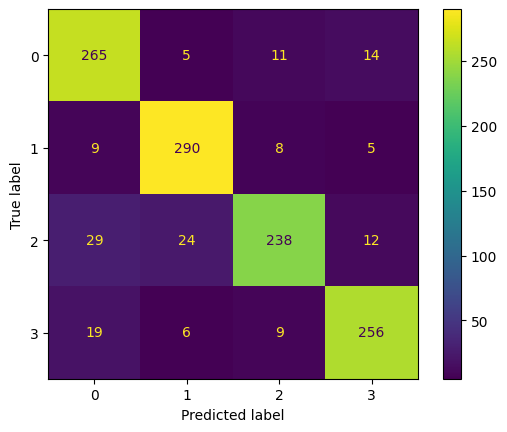

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(ytest_cpu, test_preds_cpu)

In [36]:
from sklearn.metrics import classification_report

print(classification_report(ytest_cpu, test_preds_cpu))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       295
           1       0.89      0.93      0.91       312
           2       0.89      0.79      0.84       303
           3       0.89      0.88      0.89       290

    accuracy                           0.87      1200
   macro avg       0.88      0.87      0.87      1200
weighted avg       0.88      0.87      0.87      1200

